# Initial Analysis of the OUP and Relevant Code Provided 

This notebook serves to convert much of the MATLAB code to Python, provided for implementing the OUP as part of the COMP0043: Numerical Methods for Finance module on moodle. This code was recommended by the project supervisor for use, and was suggested as a good starting point for understanding the main tasks relevant to the project.

In [1]:
''' Module imports and declarations '''
%matplotlib inline
import math
import statistics
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.ticker as mticker
from scipy.stats import norm
from matplotlib.pyplot import figure

In [2]:
''' Simulate an Ornstein-Uhlenbeck process '''
# dX = alpha*(mu-X)*dt + sigma*dW
np.random.seed(8)

# Define parameters and time grid
npaths = 20000                   # number of paths
T = 1                            # time horizon
nsteps = 200                     # number of time steps
dt = T / nsteps                  # time step  
t = np.linspace(0, T, nsteps+1)  # observation times

# model parameters
alpha = 5
mu = 0.07 
sigma = 0.07

# initial value, X_0
X0 = 0.03         

''' Allocate and initialise all paths '''
X = [[X0] * npaths]
for i in range(nsteps):
    X.append([0] * npaths)
X = np.array(X)

# Sample standard Gaussian random numbers
N = np.random.normal(0, 1, (nsteps, npaths))

''' The following block is responsible for the actual generation of the OU paths '''
# Compute the standard deviation for a time step
# sdev = sigma * math.sqrt(dt)                                           # plain Euler                          
sdev = sigma * math.sqrt((1 - math.exp(-2 * alpha * dt)) / (2 * alpha))  # Euler with analytic moments

# Compute and accumulate the increments
for i in range(nsteps):
    # X[i + 1] = X[i] + alpha * (mu * X[i]) * dt + sdev * N[i]          # plain Euler
    X[i + 1] = mu + (X[i] - mu) * math.exp(-alpha * dt) + sdev * N[i]   # Euler with analytic moments
    
# Compute the expected path
EX = []
for i in range(len(t)):
    val = mu + (X0 - mu) * math.exp(-alpha * t[i])
    EX.append(val)
    
# Compute the mean path - Python alternative
mean = []
for i in range(len(X)):
    mean.append(np.mean(X[i]))

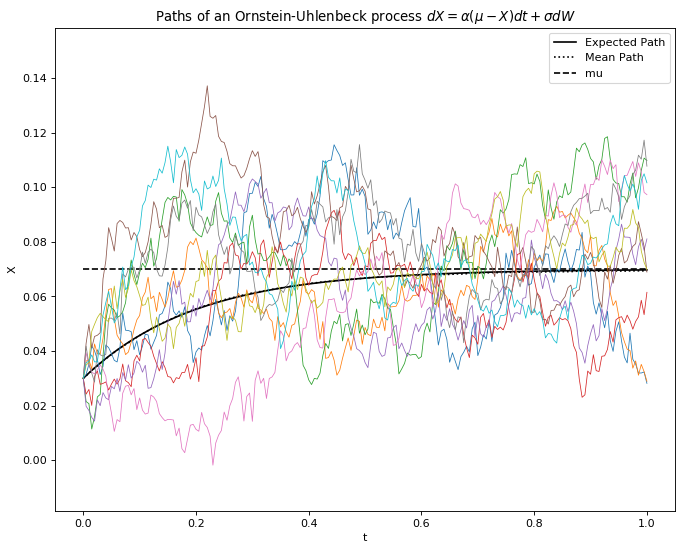

In [3]:
''' Plot the expected/mean/sample paths and mu '''
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

# This is from the original script, believe the first 3 lines are repeated at the end too
# plot(t,EX,'k',t,mean(X,2),'k:',t,mu*ones(size(t)),'k--',t,X(:,1:1000:end),t,EX,'k',t,mean(X,2),'k:',t,mu*ones(size(t)),'k--')

plt.plot(t, EX, 'k', label='Expected Path')
plt.plot(t, mean, 'k:', label='Mean Path')
plt.plot(t, [mu] * len(t), 'k--', label='mu')

for i in range(10):
    plt.plot(t, X[:,i], linewidth=0.7)
    
plt.legend()
plt.xlabel('t')
plt.ylabel('X')
plt.title(r'Paths of an Ornstein-Uhlenbeck process $dX = \alpha(\mu-X)dt + \sigma dW$')

sdevinfty = sigma / math.sqrt(2 * alpha)
plt.ylim((mu-4*sdevinfty,mu+4*sdevinfty))
plt.show()

In [4]:
class MathTextSciFormatter(mticker.Formatter):
    def __init__(self, fmt="%1.2e"):
        self.fmt = fmt
    def __call__(self, x, pos=None):
        s = self.fmt % x
        decimal_point = '.'
        positive_sign = '+'
        tup = s.split('e')
        significand = tup[0].rstrip(decimal_point)
        sign = tup[1][0].replace(positive_sign, '')
        exponent = tup[1][1:].lstrip('0')
        if exponent:
            exponent = '10^{%s%s}' % (sign, exponent)
        if significand and exponent:
            s =  r'%s{\times}%s' % (significand, exponent)
        else:
            s =  r'%s%s' % (significand, exponent)
        return "${}$".format(s)

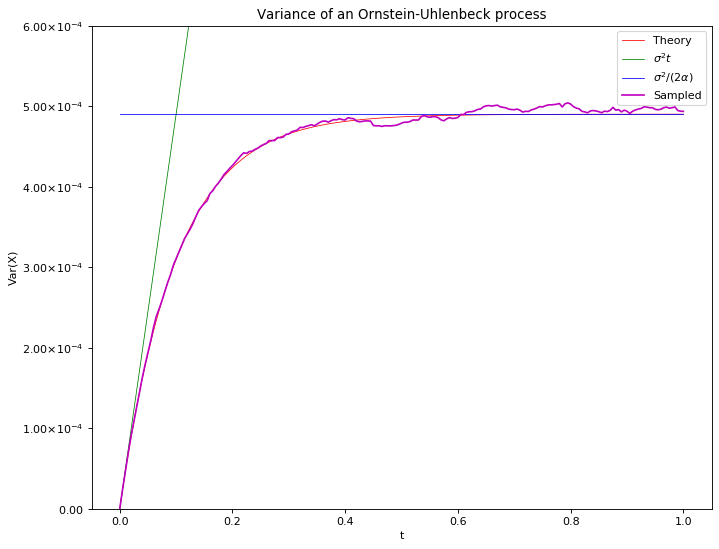

In [5]:
''' Plot the variance '''
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

exp_var_line = []
for i in range(len(t)):
    val = sigma**2 / (2 * alpha) * (1 - math.exp(-2 * alpha * t[i]))
    exp_var_line.append(val)
    
variance = []
for i in range(len(X)):
    variance.append(np.var(X[i]))
    
plt.plot(t, exp_var_line, 'r', linewidth=0.7, label='Theory')
plt.plot(t, (sigma**2) * t, 'g', linewidth=0.7, label=r'$\sigma^2 t$')
plt.plot(t, [sigma**2 / (2 * alpha)] * len(t), 'b', linewidth=0.7, label=r'$\sigma^2 / (2 \alpha)$')
plt.plot(t, variance, 'm', label='Sampled')

plt.ylim((0, 0.0006))
plt.gca().yaxis.set_major_formatter(MathTextSciFormatter("%1.2e"))
plt.xlabel('t')
plt.ylabel('Var(X)')
plt.legend()
plt.title('Variance of an Ornstein-Uhlenbeck process')

plt.show()

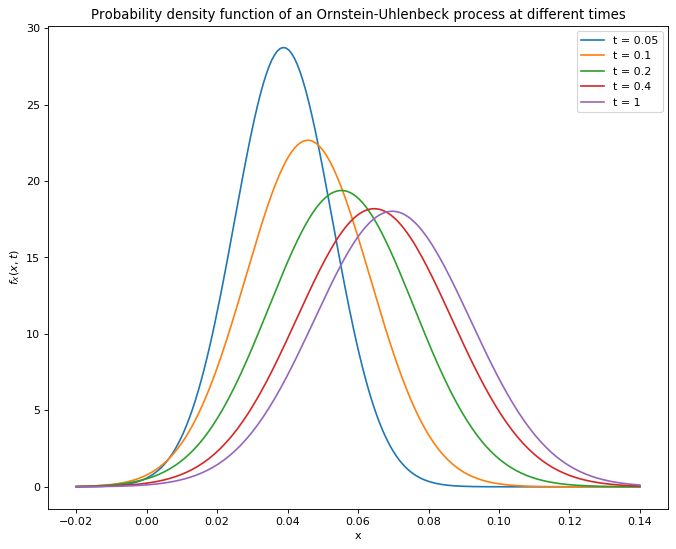

In [6]:
''' Compute and plot the probability density function at different times '''
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

x = np.linspace(-0.02, 0.14, nsteps)
t2 = [0.05, 0.1, 0.2, 0.4, 1]

EX2 = []
for i in range(len(t2)):
    EX2.append(mu + (X0 - mu) * math.exp(-alpha * t2[i]))
    
sdev = []
for i in range(len(t2)):
    val = sigma * math.sqrt((1 - math.exp(-2 * alpha * t2[i])) / (2 * alpha))
    sdev.append(val)
    
f = np.zeros((len(x), len(t2)))
for i in range(len(t2)):
    f[:,i] = norm.pdf(x, EX2[i], sdev[i])
    plt.plot(x, f[:,i], label="t = " + str(t2[i]))

plt.legend()
plt.xlabel('x')
plt.ylabel(r'$f_X(x,t)$')
plt.title('Probability density function of an Ornstein-Uhlenbeck process at different times')
plt.show()

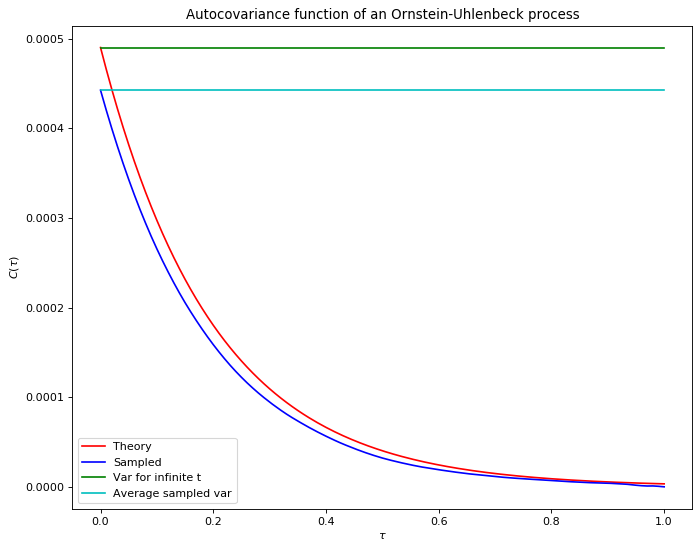

In [7]:
''' Compute and plot the autocovariance function '''
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
sigma_exp = []
for i in range(len(t)):
    val = sigma**2 / (2 * alpha) * math.exp(-alpha * t[i])
    sigma_exp.append(val)

# t,sigma^2/(2*alpha)*exp(-alpha*t),'r'
plt.plot(t, sigma_exp, 'r', label="Theory")

C = np.zeros((2*nsteps+1, npaths))
for j in range(npaths):  
    path = X[:,j] - EX
    corr = np.correlate(path, path, "full")
    lags = np.arange(-(path.size - 1), path.size)
    corr /= (path.size - abs(lags))
    C[:,j] = corr

# C = mean(C,2);
mean = []
for i in range(len(C)):
    mean.append(np.mean(C[i]))
C = mean

# t,C(nsteps+1:end),'b'
plt.plot(t, C[nsteps:], 'b', label="Sampled")

# t,sigma^2/(2*alpha)*ones(size(t)),'g'
plt.plot(t, [sigma**2 / (2 * alpha)] * len(t), 'g', label="Var for infinite t")

# t,mean(var(X,0,2))*ones(size(t)),'c'
variance = []
for i in range(len(X)):
    variance.append(np.var(X[i]))
plt.plot(t, [np.mean(variance)] * len(t), 'c', label="Average sampled var")
    
plt.xlabel(r'$\tau$')
plt.ylabel(r'$C(\tau)$')
plt.title('Autocovariance function of an Ornstein-Uhlenbeck process')
plt.legend()
plt.show()

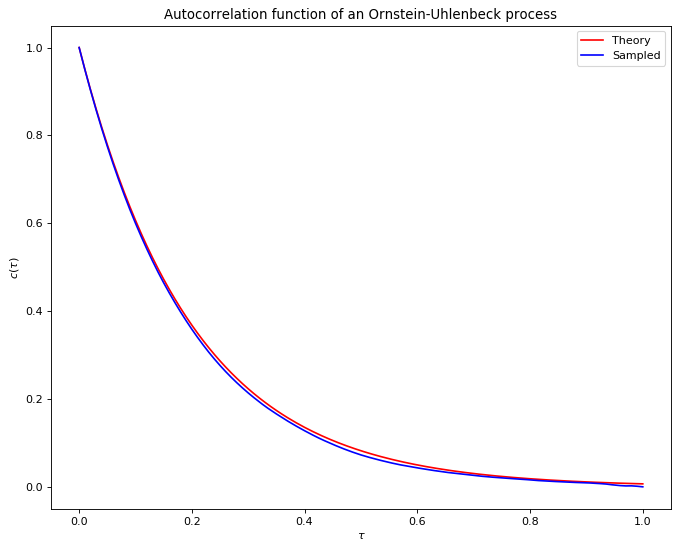

In [8]:
''' Plot the autocorrelation function '''
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

# t,exp(-alpha*t),'r'
alpha_exp = []
for i in range(len(t)):
    alpha_exp.append(math.exp(-alpha * t[i]))
    
plt.plot(t, alpha_exp, 'r', label="Theory")

# t,C(nsteps+1:end)/C(nsteps+1),'b'
plt.plot(t, C[nsteps:]/C[nsteps], 'b', label="Sampled")

plt.xlabel(r'$\tau$')
plt.ylabel(r'$c(\tau)$')
plt.title('Autocorrelation function of an Ornstein-Uhlenbeck process')
plt.legend()
plt.show()